In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

$$
\begin{aligned}
&\frac{\partial L}{\partial p_u}=0 \Rightarrow p_u=\left(Q^TC_u Q+\lambda I\right)^{-1} Q^T C_u \phi_u \\
&\frac{\partial L}{\partial q_i}=0 \Rightarrow q_i=\left(P^TC_i P+\lambda I\right)^{-1} P^T C_i \phi_i
\end{aligned}
$$

$$
\begin{aligned}
&\frac{\partial L}{\partial p_u}=0 \Rightarrow p_u=\left(Q^T Q+Q^T\left(C_u-I\right) Q+\lambda I\right)^{-1} Q^T C_u \phi_u \\
&\frac{\partial L}{\partial q_i}=0 \Rightarrow q_i=\left(P^T P+P^T\left(C_i-I\right) P+\lambda I\right)^{-1} P^T C_i \phi_i
\end{aligned}
$$

$$ L\left(p_u, q_i, r_{u i}\right)=\sum_{u, i \in R} c_{u i} \cdot\left(\phi_{u i}-\langle p_u, q_i \rangle\right)^2=\sum_{u, i \in R}\left(1+\alpha r_{u i}\right)\left(\phi_{u i}-\langle p_u, q_i \rangle\right)^2 $$

In [ ]:
class ImplicitALS:
    def __init__(self, R, k=3, a=40, l2=10):
        self.l2 = l2
        self.k = k
        self.a = a
        self.m, self.n = R.shape
        self.P = np.random.rand(self.m, self.k)
        self.Q = np.random.rand(self.n, self.k)
        self.phi = np.where(R > 0, 1, 0)
        self.C = 1 + a * R
        self.loss = []

    def train(self, n_step=10):
        l2_reg = self.l2 * np.identity(self.k)
        for _ in range(n_step):

            # fix P, update Q
            PtP = self.P.T.dot(self.P)

            for i in range(self.n):
                Ci = np.diag(self.C[:, i])
                Wi = PtP + self.P.T.dot(Ci - np.identity(self.m)).dot(self.P) + l2_reg
                self.Q[i] = np.linalg.inv(Wi).dot(self.P.T).dot(Ci).dot(self.phi[:, i])

            # fix Q, update P
            QtQ = self.Q.T.dot(self.Q)
            for u in range(self.m):
                Cu = np.diag(self.C[u, :])
                Wu = QtQ + self.Q.T.dot(Cu - np.identity(self.n)).dot(self.Q) + l2_reg
                self.P[u] = np.linalg.inv(Wu).dot(self.Q.T).dot(Cu).dot(self.phi[u, :])

            loss = (self.C*(self.phi - self.P.dot(self.Q.T))**2).sum()
            l2_all = (self.P ** 2).sum() + (self.Q ** 2).sum()
            self.loss.append(loss + self.l2 * l2_all)


    def predict(self, u, i):
        return self.P[u].dot(self.Q[i])

In [ ]:
np.random.seed(42)

In [ ]:
stars = np.arange(6)
p = np.array([10, 1, 1, 1, 1, 1])
m = 5
n = 10

ratings = np.random.choice(stars, size=m*n, p=p / p.sum()).reshape((m, n))

In [ ]:
ratings

array([[0, 5, 1, 0, 0, 0, 0, 3, 0, 1],
       [0, 5, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 5, 5, 3, 0, 0, 1, 0],
       [0, 0, 0, 4, 0, 0, 0, 0, 0, 0]])

In [ ]:
ratings.shape

(5, 10)

In [ ]:
als = ImplicitALS(R=ratings, k=20)

In [ ]:
als.train(n_step=50)

In [ ]:
als.loss[:5]

[np.float64(245.43794448124567),
 np.float64(190.01384136209407),
 np.float64(165.32695425572288),
 np.float64(151.22063653819146),
 np.float64(142.51063458040846)]

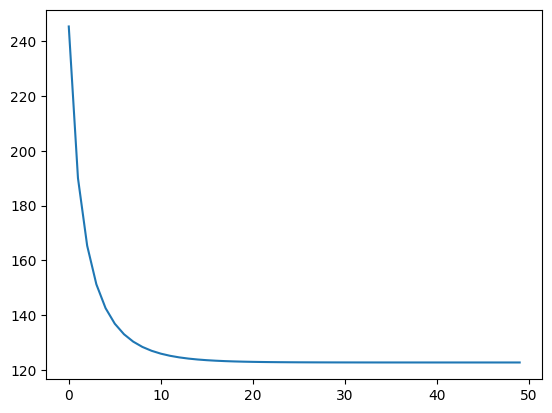

In [ ]:
ax = sns.lineplot(als.loss)

In [ ]:
als.P.shape, als.Q.shape

((5, 20), (10, 20))

In [ ]:
als.P

array([[ 0.57266048,  0.12609971, -0.17706221,  0.39119574,  0.15599883,
         0.33169319,  0.15036896, -0.14981436, -0.07120173, -0.19968314,
         0.26421699,  0.09835032,  0.18710543, -0.03378566,  0.0336248 ,
         0.18304091,  0.12776908,  0.17479678,  0.58412224,  0.33889988],
       [ 0.43630894,  0.02419501, -0.29441547,  0.31883727,  0.14214997,
         0.2464388 ,  0.24055982, -0.15667642, -0.02440249, -0.23788802,
         0.26688299,  0.15187184,  0.06366007, -0.07133108,  0.05608225,
         0.12108612,  0.19778862,  0.12296263,  0.63997709,  0.18554464],
       [-0.18852672,  0.21392503,  0.34178188,  0.11349175,  0.25674481,
         0.09564052,  0.24083893,  0.18744073,  0.06976241,  0.04091326,
        -0.07965199,  0.3029685 ,  0.00118021,  0.1961124 ,  0.39242258,
         0.04053025,  0.18136741,  0.25887321, -0.02412417, -0.13854647],
       [-0.13204164,  0.12544097,  0.2398805 ,  0.06977821,  0.4823854 ,
         0.06807984,  0.34168201,  0.43119186,  

In [ ]:
pred_ratings = np.matmul(als.P, als.Q.T).round(2)

In [ ]:
for row in range(ratings.shape[0]):
    print('Original:')
    print(ratings[row, :])
    print('Predicted:')
    print(pred_ratings[row, :])

Original:
[0 5 1 0 0 0 0 3 0 1]
Predicted:
[ 0.    1.    0.98 -0.    0.    0.    0.    0.94  0.    0.84]
Original:
[0 5 3 0 0 0 0 0 0 0]
Predicted:
[ 0.    0.96  0.94  0.   -0.   -0.    0.    0.83 -0.    0.74]
Original:
[0 0 0 0 0 2 0 0 0 0]
Predicted:
[ 0.   -0.   -0.    0.23  0.55  0.88  0.    0.    0.49  0.  ]
Original:
[0 0 0 5 5 3 0 0 1 0]
Predicted:
[ 0.   -0.   -0.    0.99  0.96  0.99  0.    0.    0.85  0.  ]
Original:
[0 0 0 4 0 0 0 0 0 0]
Predicted:
[ 0.    0.    0.    0.94  0.56  0.24  0.   -0.    0.49 -0.  ]


In [ ]:
ratings[-1, :]

array([0, 0, 0, 4, 0, 0, 0, 0, 0, 0])

In [ ]:
als.P[-1, :].dot(als.Q.T).round(2)

array([ 0.  ,  0.  ,  0.  ,  0.94,  0.56,  0.24,  0.  , -0.  ,  0.49,
       -0.  ])

In [ ]:
ratings[1, :]

array([0, 5, 3, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
als.P[1, :].dot(als.Q.T).round(2)

array([ 0.  ,  0.96,  0.94,  0.  , -0.  , -0.  ,  0.  ,  0.83, -0.  ,
        0.74])